In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import datetime
from datetime import date

In [2]:
file=os.path.join('x:/Marphys_Archive','Data','OSNAP','RHADCP','RHADCP_S55_data_JC238','S200044A008_RHADCP_2020','S200044A008_RHADCP_2020_A0.whr')
#  extract the header data
with open(file) as file:
    for line in file:
        print(line.rstrip())

[X:\Marphys_Archive\Data\OSNAP\RHADCP\RHADCP_S55_data_JC238\S200044A008_RHADCP_2020\S200044A008_RHADCP_2020_A0.prf]
---------------------------------------------------------------------
Number of measurements                30863
Number of checksum errors             0
Time of first measurement             15/10/2020 11:30:01.001
Time of last measurement              20/07/2022 10:30:55.001

Hardware configuration
---------------------------------------------------------------------
Instrument name                       Signature55
Serial number                         200044
Head frequency                        55 kHz
Firmware version                      169.2211_4
Pressure sensor                       YES
Compass                               YES
Tilt sensor                           YES
Temperature sensor                    YES
Number of head beams                  3

Deployment configuration
---------------------------------------------------------------------
Sound speed        

In [3]:
file=os.path.join('x:/Marphys_Archive','Data','OSNAP','RHADCP','RHADCP_S55_data_JC238','S200044A008_RHADCP_2020','S200044A008_RHADCP_2020_A0_p.dat')
file

'x:/Marphys_Archive\\Data\\OSNAP\\RHADCP\\RHADCP_S55_data_JC238\\S200044A008_RHADCP_2020\\S200044A008_RHADCP_2020_A0_p.dat'

In [4]:
#  extract the header from each ensemble period
with open(file) as f:
    lines = f.readlines()
desired_lines = lines[0:1759135:57]

#  print to file then read again bu tis time concatenate the times
with open("header.txt", "w") as f:
    f.writelines(desired_lines)
    

In [5]:
# Extract timestamp and other array tyoe variables Month  Day Year Hour Minute Secon
timestamp=[]
pitch=[]
roll=[]
heading=[]
pressure=[]
temperature=[]

with open('header.txt') as f:
    lines = f.readlines()       
    for x in lines:
            y=int(x.split()[2])
            m=int(x.split()[0])
            d=int(x.split()[1])
            h=int(x.split()[3])
            mn=int(x.split()[4])
            s=int(x.split()[5])
            d=datetime.datetime(y,m,d,h,mn,s)
            time=d.isoformat()
            timestamp.append(time)
            #heading
            h=float(x.split()[10])
            heading.append(h)            
            # pitch
            p=int(float(x.split()[11]))
            pitch.append(p)
            # roll
            r=int(float(x.split()[12]))
            roll.append(r)
            # temperature
            t=float(x.split()[14])
            temperature.append(t)
            # pressure
            P=int(float(x.split()[13]))
            pressure.append(P)           
            
            
time = np.array(timestamp, dtype='datetime64')
pressure=np.array(pressure,dtype='int64')
heading=np.array(heading,dtype='int64')
pitch=np.array(pitch,dtype='int64')
roll=np.array(roll,dtype='int64')
temperature=np.array(temperature,dtype='int64')

In [6]:
# extract sdampe data, store in bin by time array and save as int64
with open(file) as f:
    lines = f.readlines()
    
start=1
stop=1
while stop<1759191:
    stop=start+56
    templines=lines[start:stop]
    start=stop+1
    templines
    if start==58:
        # get bin number coordinate
        bin=[]
        for x in templines:
            bin.append(x.split()[0])
        bin_num=np.array([int(x) for x in bin])
        # get first velocity measurement
        vele=[]
        veln=[]
        velu=[]
        for x in templines:
            vele.append(x.split()[2])
            veln.append(x.split()[3])
            velu.append(x.split()[4])
        vel_east=np.array([int(float(x)) for x in vele])
        vel_north=np.array([int(float(x)) for x in veln])
        vel_up=np.array([int(float(x)) for x in velu])
    else:
        vele=[]
        veln=[]
        velu=[]
        for x in templines:
            vele.append(x.split()[2])
            veln.append(x.split()[3])
            velu.append(x.split()[4])
        velex=np.array([int(float(x)) for x in vele],dtype='int64') 
        velnx=np.array([int(float(x)) for x in veln],dtype='int64')        
        velux=np.array([int(float(x)) for x in velu],dtype='int64')        
        vel_east=np.c_[ vel_east, velex ]          
        vel_north=np.c_[ vel_north, velnx ]          
        vel_up=np.c_[ vel_up, velux ]  

In [14]:
whos

Variable          Type             Data/Info
--------------------------------------------
NamespaceMagics   MetaHasTraits    <class 'IPython.core.magi<...>mespace.NamespaceMagics'>
P                 int              0
bin               list             n=56
bin_num           ndarray          56: 56 elems, type `int32`, 224 bytes
d                 datetime         2022-07-20 10:30:01
date              type             <class 'datetime.date'>
datetime          module           <module 'datetime' from '<...>onda3\\lib\\datetime.py'>
desired_lines     list             n=30863
ds                Dataset          <xarray.Dataset>\nDimensi<...>cessed quality controlled
f                 TextIOWrapper    <_io.TextIOWrapper name='<...>de='r' encoding='cp1252'>
file              str              x:/Marphys_Archive\Data\O<...>A008_RHADCP_2020_A0_p.dat
get_ipython       function         <function get_ipython at 0x000002814B5AFCA0>
h                 float            300.4
heading           ndarray  

In [21]:
#  create dataset using OCEANsites format
ds = xr.Dataset(
    {"velocity_east": (("bin", "time"), vel_east,
                        {'units':'m s-1','description':'eastward_sea_water_velocity'}),
        "velocity_north": (("bin", "time"), vel_north,
                        {'units':'m/s','description':'northward_sea_water_velocity'}),
        "velocity_up": (("bin", "time"), vel_up,
                        {'units':'m/s','description':'Velocity (Beam3|Z|Up)'}),
        "temperature": (( "time"), temperature,
                        {'units':'degrees Celsius','description':'temperature at sensor head'}),
        "pressure": (( "time"), pressure,{'units':'decibars'}),
        "heading": (( "time"), heading, {'units':'degrees'}),
        "pitch": (( "time"), pitch,{'units':'degrees'}),
        "roll": (( "time"), roll,{'units':'degrees'})
    },
    coords={
        "BIN": bin_num,
        "TIME": time,
    },
  attrs={"principal_investigator": "Stuart Cunningham",
          "principal_investigator_email": "stuart.cunningham@sams.ac.uk",
          "principal_investigator_url": "http://www.sams.ac.uk",
          "institution": "Scottish Association for Marine Science, SAMS",
          "contributor_name": "Lewis Drysdale",
          "contributor_role": "data processing and interpretation",
          "contributor_email": "lewis.drysdale@sams.ac.uk",
          "project": "OSNAP",
          "history": "Delayed time processed quality controlled",
          "processing_level":"calibrated;good data",
          "sensor_manufacturer": "Nortek",
          "sensor_model": "Signature 55",
          "sens_orientation": "upward",
          "sensor_mount": "mounted_on_seafloor_structure ",
          "coordsyst": "East-North-Up"},
)

In [22]:
ds

<xarray.Dataset>
Dimensions:         (BIN: 56, TIME: 30863, bin: 56, time: 30863)
Coordinates:
  * BIN             (BIN) int32 1 2 3 4 5 6 7 8 9 ... 48 49 50 51 52 53 54 55 56
  * TIME            (TIME) datetime64[ns] 2020-10-15T11:30:01 ... 2022-07-20T...
Dimensions without coordinates: bin, time
Data variables:
    velocity_east   (bin, time) int64 -9 -9 -9 -9 -9 -9 -9 ... -9 -9 -9 -9 -9 0
    velocity_north  (bin, time) int64 -9 -9 -9 -9 -9 -9 -9 ... -9 -9 -9 -9 -9 0
    velocity_up     (bin, time) int64 -9 -9 -9 -9 -9 -9 -9 ... -9 -9 -9 -9 -9 0
    temperature     (time) int64 14 14 15 15 14 14 14 14 14 ... 5 5 5 5 5 5 9 12
    pressure        (time) int64 0 0 0 0 0 0 0 ... 1076 1077 1077 1077 306 0
    heading         (time) int64 91 97 150 137 146 120 ... 328 328 329 21 300
    pitch           (time) int64 -23 -26 -85 -86 -86 -85 ... -1 -1 -1 0 0 -15
    roll            (time) int64 -45 -41 12 16 8 21 14 16 ... 0 1 1 0 0 0 12 -77
Attributes: (12/15)
    principal_investigator:        Stuart Cunningham
    principal_investigator_email:  stuart.cunningham@sams.ac.uk
    principal_investigator_url:    http://www.sams.ac.uk
    institution:                   Scottish Association for Marine Science, SAMS
    contributor_name:              Lewis Drysdale
    contributor_role:              data processing and interpretation
    ...                            ...
    processing_level:              calibrated;good data
    sensor_manufacturer:           Nortek
    sensor_model:                  Signature 55
    sens_orientation:              upward
    sensor_mount:                  mounted_on_seafloor_structure 
    coordsyst:                     East-North-Up

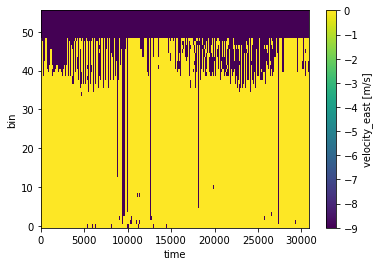

In [20]:
ds.velocity_east.plot()

In [23]:
ds.to_netcdf("../data/RHADCP_D.nc")